### Self-organized criticality

В случае с перколяцией можно было заметить, что при значении пористости среды около p=0.6 наблюдается фазовый переход. Структура, которая при этом возникает, является фрактальной. Это одно из свойств критических систем. В природе такое встречается довольно часто. Одно из объяснений этого факта - некоторые системы самопроизвольно эволюционируют в направлении к критическим состояниям и удерживаются в нем, в силу устойчивости такого состояния (Self-organized criticality). В то же время для других систем критическое состояние является неустойчивым.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import correlate2d

# make a directory for figures
!mkdir figures

from os.path import basename, exists
def download(url):
    fileName = basename(url)
    if not exists(fileName):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, fileName)
        print(f'Downloaded {local}')

download('https://github.com/wernadsky/test/raw/master/cell2d.py')
download('https://github.com/wernadsky/test/raw/master/utils.py')

from cell2d import Cell2D, draw_array, add_island, multi_frame, three_frame
from utils import decorate
import itertools

Џ®¤Ї ЇЄ  Ё«Ё д ©« figures г¦Ґ бгйҐбвўгҐв.


In [2]:
class SandPile(Cell2D):
    def __init__(self, n, m=None, level=9):
        """ level - начальное значение для всех клеток """
        m = n if m is None else m
        self.array = np.ones((n, m), dtype=np.int32) * level
        self.toppledSeq = []

    kernel = np.array([ [0, 1, 0],
                        [1,-4, 1],
                        [0, 1, 0] ])

    def step(self, k=3):
        """ возвращает количество опрокинутых клеток """
        toppling = self.array > k
        numToppled = np.sum(toppling)
        # число опрокидываний за один шаг добавляется в self.toppledSeq
        self.toppledSeq.append(numToppled)

        c = correlate2d(toppling, self.kernel, mode='same')
        self.array += c
        return numToppled

    def drop(self):
        """ Кинуть песчинку в случайную клетку """
        a = self.array
        n, m = a.shape
        index = np.random.randint(n), np.random.randint(m)
        a[index] += 1

    def run(self):
        """ Запуск симуляции; остановка при достижении равновесия
         
        возвращает: длительность процесса, число опрокидываний клеток
        """
        total = 0
        for i in itertools.count(1):
            numToppled = self.step()
            total += numToppled
            if numToppled == 0:
                return i, total

    def drop_and_run(self, iters=1):
        self.drop()
        duration, totalToppled = self.run()
        return duration, totalToppled
        
    def draw(self, size=None):
        draw_array(self.array, size, cmap='YlOrRd', vmax=5)

In [3]:
# создадим простейший мир, дабы наглядно посмотреть один шаг
pile = SandPile(n=3, m=5, level=0)
pile.array[1, 1] = 4
pile.array[1, 3] = 4

a = pile.array
print(a)                        # исходное состояние

toppling = a > 3
print(toppling.astype(int))     # клетки с избыточным значением

print(SandPile.kernel)          # ядро преобразования

c = correlate2d(toppling, SandPile.kernel, mode='same', boundary='fill')
print(c)                        # корреляционная матрица

a += c
print(a)                        # следующее состояние

[[0 0 0 0 0]
 [0 4 0 4 0]
 [0 0 0 0 0]]
[[0 0 0 0 0]
 [0 1 0 1 0]
 [0 0 0 0 0]]
[[ 0  1  0]
 [ 1 -4  1]
 [ 0  1  0]]
[[ 0  1  0  1  0]
 [ 1 -4  2 -4  1]
 [ 0  1  0  1  0]]
[[0 1 0 1 0]
 [1 0 2 0 1]
 [0 1 0 1 0]]


(1781, 1838376)


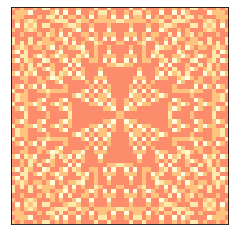

In [8]:
# запустим симуляцию до ее полного завершения
pile = SandPile(n=50, level=10)
print(pile.run())
pile.draw()

In [4]:
# на каждом шаге анимации добавляется одна песчинка в случайную
# клетку, затем запускается до полного завершения
fig = pile.animate(frames=1001, step=pile.drop_and_run)

<Figure size 432x288 with 0 Axes>

(332, 53336)


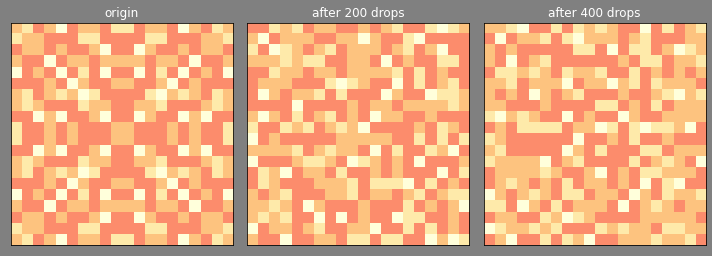

In [16]:
pile = SandPile(n=20, level=10)
print(pile.run())

fig = plt.figure(figsize=(10, 4), facecolor='grey')

ax1 = plt.subplot(1, 3, 1)
ax1.set_title('origin', color='w')
pile.draw()

ax2 = plt.subplot(1, 3, 2)
ax2.set_title('after 200 drops', color='w')
for i in range(200):
    pile.drop_and_run()
pile.draw()

ax3 = plt.subplot(1, 3, 3)
ax3.set_title('after 400 drops', color='w')
for i in range(400):
    pile.drop_and_run()
pile.draw()
fig.tight_layout()
fig.savefig('figures/sands')
# заметим, что картина после 200 бросков не отличается принципиально от 400

#### Тяжелые хвосты (Heavy-tailed)

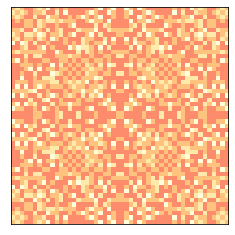

In [4]:
pile2 = SandPile(n=50, level=30)
pile2.run()
pile2.draw()

In [5]:
# произведем 100000 итераций подкидывая по песчинке и 
# запуская до остановки. Соберем кортеж res все значения длительности 
# запуска и количества опрокинутых клеток в каждом запуске (лавину)
iters = 100000
res = [pile2.drop_and_run() for _ in range(iters)]

In [6]:
T, S = np.transpose(res)
print(T.shape, S.shape)
# большинство бросков длились всего одну итерацию, при которой
# не происходило опрокидываний, так что отфильтруем массивы
T = T[T>1]
S = S[S>0]
print(T.shape, S.shape)

(100000,) (100000,)
(43160,) (43160,)


In [7]:
try:
    import empiricaldist
except:
    !pip install empiricaldist

In [8]:
from empiricaldist import Pmf

# функция Pmf.from_seq позволяет получить вероятности появления
# значений в последовательности
pmfT = Pmf.from_seq(T)
pmfS = Pmf.from_seq(S)
print(pmfT.shape, type(pmfT))

(332,) <class 'empiricaldist.empiricaldist.Pmf'>


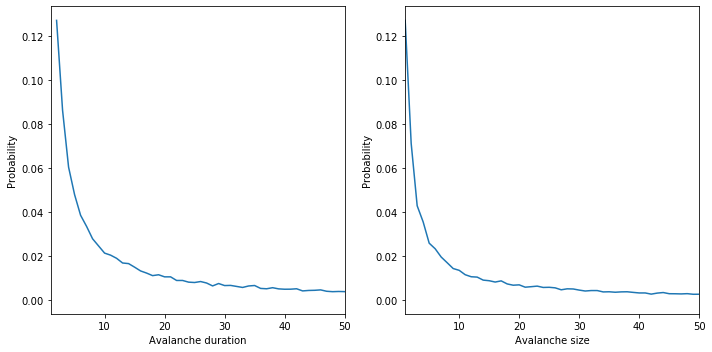

In [30]:
fig = plt.figure(figsize=(10, 5))

ax1 = plt.subplot(1, 2, 1)
pmfT.plot(label='T',
            xlabel='Avalanche duration',
            ylabel='Probability')
ax1.set_xlim([1, 50])
decorate()

ax2 = plt.subplot(1, 2, 2)
pmfS.plot(label='S',
            xlabel='Avalanche size',
            ylabel='Probability',
            xlim=[1, 50])
# ax2.set_xlim([1, 50])
decorate()


[-1.1188474]
[-1.01439469]


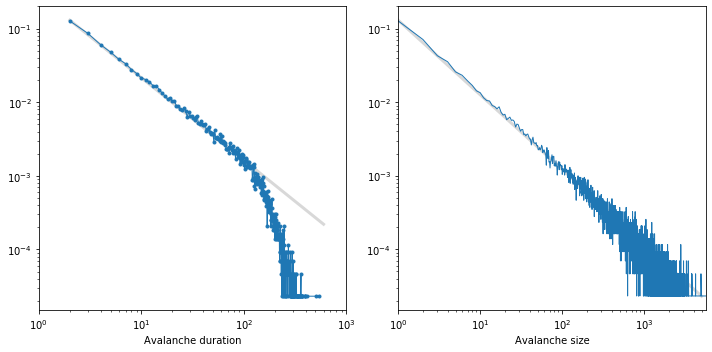

In [36]:
# логарифмическая шкала log-log

def slope(xs, ys):
    return np.diff(np.log(ys)) / np.diff(np.log(xs))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

xs = [2, 600]
ys = [1.3e-1, 2.2e-4]
print(slope(xs, ys))

options = dict(lw=3, color='gray', alpha=0.3)

plt.plot(xs, ys, **options)
pmfT.plot(lw=1, marker='.', label='T')
ax1 = plt.gca()
ax1.set_xlim([1, 1000])
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Avalanche duration')

plt.subplot(1, 2, 2)

xs = [1, 5000]
ys = [1.3e-1, 2.3e-5]
print(slope(xs, ys))

plt.plot(xs, ys, **options)
pmfS.plot(lw=1, marker='', label='S')
decorate(xlabel='Avalanche size',
                 xlim=[1, 5600],
                 xscale='log',
                 yscale='log')

На log-log графике значения от 1 до 100 лежат почти на прямой, что характерно для тяжелого хвоста. Серые линии имеют наклон около -1, что говорит о том, что эти распределения следуют степенному закону (а не экспоненциальному) с параметром около $\alpha=1$. Для значений более 10 распределение падает быстрее степенного закона. Возможно этот эффект вызван ограниченностью размера кучи.<br>

Стоит отметить, что для тяжелых хвостов характерны не только степенные законы распределения. Во всяком случае, в силу неэкспоненциаьного убывания появление высоких значений оказывается весьма вероятным, что делает поведение системы болшее непредсказуемым.

#### Фракталы
Раз песочная куча пребывает в критическом состоянии, можно ожидать от нее фрактальную геометрию. Для оценки размерности фрактальной размерности, можно запустить кучу большего размера и более высокого уровня инициализации

Wall time: 17.4 s


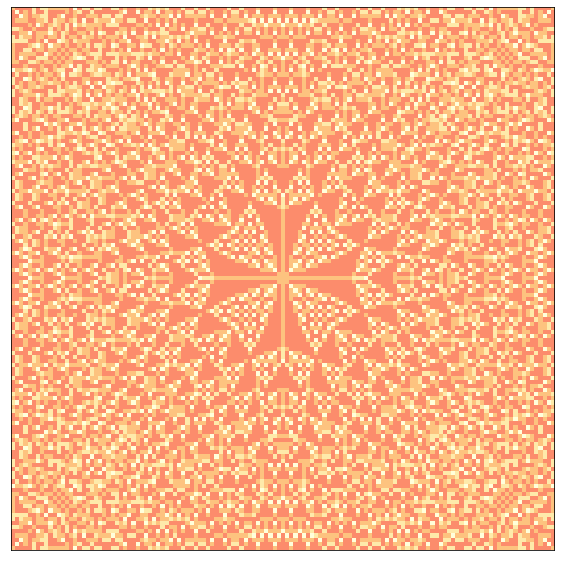

In [25]:
pile3 = SandPile(n=131, level=22)
%time pile3.run()
pile3.draw(size=10)

In [47]:
def draw_four(pile, levels=range(4)):
    plt.figure(figsize=(20, 20))
    for i, level in enumerate(levels):
        plt.subplot(2, 2, i+1)
        draw_array(pile.array==level, size=6, cmap='YlOrRd', vmax=1)

    plt.tight_layout()

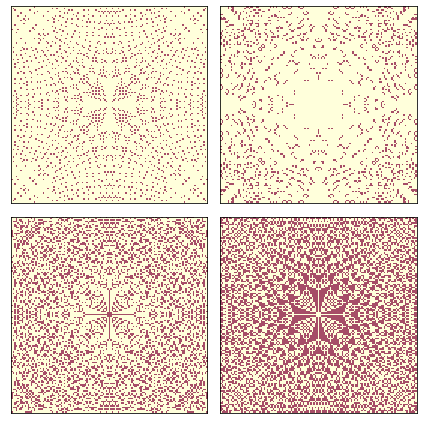

In [45]:
draw_four(pile3)

Выглядит как фрактал, но внешность может быть обманчивой. В коде Downey есть оценка размерностей, для того, чтобы убедиться во фрактальности структуры.

#### Pink Noise

<b>Сигналом</b> можно назвать некоторую величину, меняющуюся во времни. В случае с песчанной кучей, в качестве сигнала можно рассматривать длительность процесса опрокидывания клеток до полного завершения.  

Сигнал можно разложить по частотам с различными уровнями вклада, в соответствии с амплитудой, характеризуемое <b>Спектральной плотностью</b> (Power Spectrum).

<b>Шум</b> в данном контексте представляет собой сигнал, содержащий много частотных компонентов. <b>Белый шум</b> представляет собой сигнал, который содержит широкий диапазон частот с равным вкладом. В <b>красном шумe</b> вклад частоты $f$ убывает по закону $P(f)=1/f^2$. Если обобщить, $$P(f)=1/f^\beta$$ При $\beta=0$ получаем белый шум, при $\beta=2$ - красный шум. При $\beta$ близком к 1 результат назыавется $1/f$ шумом. А в общем случае, при любом значении между 0 и 2 шум называется <b>розовым</b>.

Для систем находящихся в критическом состоянии характерен розовый шум. Для того, чтобы составить тест на розовый шум, можно воспользоваться логарифмической шкалой, логарифмировав обе части: $$\log P(f) = -\beta \log f$$ Так что если нарисовать функцию $P(f)$ на log-log координатах, мы ожидаем увидеть прямую с наклоном $-\beta$.

При каждом запуске step() в список toppledSeq добавляется количество опрокинутых клеток за один шаг. Эта последовательность, собранная в результате 100000 запусков drop_and_run() будет служить в данном случае сигналом, наподобие звука. Так что можно можно говорить о спектральной плотности.

In [38]:
from scipy.signal import welch
signal = pile2.toppledSeq       # сигнал
print(len(signal))
nPerSeg = 2048                  # длина сегмента


# Подсчет спектральной плотности методом Вельча
freqs, powers = welch(signal, nperseg=nPerSeg, fs=nPerSeg)
# fs - частота дискретизации сигнала как временного ряда
# nperseg - длина одного сегмента
print(len(signal) / nPerSeg)
print(len(freqs))

1436653
701.49072265625
1025


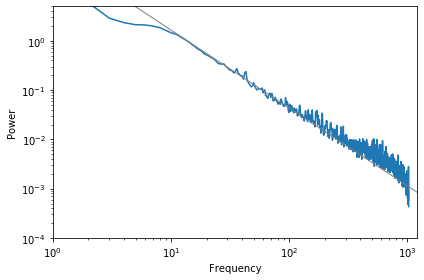

In [57]:
# Отобразим график спектарльной плотности
plt.plot(freqs, powers)
d = dict(
    xscale='log',
    yscale='log',
    xlim=[1, 1200],
    ylim=[1e-4, 5],
    xlabel='Frequency',
    ylabel='Power'
)
decorate(**d)

# подберем аппроксимирующую прямую. Величина ее наклона будет соответстовать
# степени убывания. Для построения прямой используем две точки:

slope = 1.58    # подбираем вручную, если 0 < splope < 2 - шум розовый
x = nPerSeg
ys = np.array([x**slope, 1]) / ((np.e) * 1000)

plt.plot([1, x], ys, color='gray', linewidth=1)